In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Import data

In [2]:
#btc options data
df=pd.read_csv('data/btc_data.csv', sep=",", index_col=0)

#df.drop(columns=['Unnamed: 0', 'interest_rate'], inplace=True)


##### Core Trading Data

* best_bid_amount, best_ask_amount: The quantity available at the best bid and best ask prices.
* best_bid_price, best_ask_price: The highest price buyers are willing to pay (bid) and the lowest price sellers are willing to accept (ask).
* bid_iv, ask_iv: Implied volatility of the best bid and ask.
* underlying_index: The index or ticker symbol of the underlying asset, which in this case is Bitcoin.
* underlying_price: Current price of the underlying asset.
* mark_iv: The market's consensus on implied volatility.
* open_interest: Total number of outstanding derivative contracts, such as options or futures, that have not been settled.
* max_price, min_price: Maximum and minimum prices recorded.
* last_price: The most recent price at which the option was traded.

##### Advanced Trading Metrics
* interest_rate: Interest rate used for pricing options, typically a risk-free rate.
* asks, bids: These might contain more detailed order book data in JSON or another structured format.
* settlement_price: The price used for settling trades at the end of a trading period.
* mark_price: The current market price of the contracts.
* index_price: Index price that the derivative tracks.

##### Timestamps and Changes
* change_id: An identifier for tracking changes to data points.
* timestamp: UNIX timestamp indicating the time of data retrieval.


##### Greeks
* greeks.rho: Sensitivity to the interest rate.
* greeks.theta: Sensitivity to time decay.
* greeks.vega: Sensitivity to changes in the volatility of the underlying asset.
* greeks.gamma: The rate of change of delta with respect to changes in the underlying price.
* greeks.delta: The rate of change of the option's price with respect to changes in the underlying asset's price.

##### Statistical Data
* stats.volume_usd, stats.volume: Trading volume in USD and in units.
* stats.price_change, stats.low, stats.high: Change in price, lowest, and highest price during the recording period.

##### Settlement Information
* settlement_period: The periodicity of settlement, such as daily, weekly, etc.

### Data Cleaning and Preparation

### Bitcoin

In [3]:
df.columns

Index(['best_ask_amount', 'underlying_index', 'underlying_price', 'ask_iv',
       'bid_iv', 'mark_iv', 'interest_rate', 'best_bid_price',
       'best_ask_price', 'mark_price', 'open_interest', 'max_price',
       'min_price', 'settlement_price', 'last_price', 'asks', 'bids',
       'instrument_name', 'index_price', 'change_id', 'timestamp',
       'greeks.rho', 'greeks.theta', 'greeks.vega', 'greeks.gamma',
       'greeks.delta', 'stats.volume_usd', 'stats.volume',
       'stats.price_change', 'stats.low', 'stats.high', 'settlement_period',
       'Expiration Date', 'Strike Price'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118 entries, 0.0 to 0.0
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   best_ask_amount     118 non-null    float64
 1   underlying_index    118 non-null    object 
 2   underlying_price    118 non-null    float64
 3   ask_iv              118 non-null    float64
 4   bid_iv              118 non-null    float64
 5   mark_iv             118 non-null    float64
 6   interest_rate       118 non-null    float64
 7   best_bid_price      118 non-null    float64
 8   best_ask_price      118 non-null    float64
 9   mark_price          118 non-null    float64
 10  open_interest       118 non-null    float64
 11  max_price           118 non-null    float64
 12  min_price           118 non-null    float64
 13  settlement_price    78 non-null     float64
 14  last_price          90 non-null     float64
 15  asks                118 non-null    object 
 16  bids       

In [5]:
#Get descriptive statistics
df.describe()

,best_ask_amount,underlying_price,ask_iv,bid_iv,mark_iv,interest_rate,best_bid_price,best_ask_price,mark_price,open_interest,...,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high,Strike Price
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.0,118.000000,118.000000,118.000000,118.000000,...,118.000000,118.000000,118.000000,118.000000,1.180000e+02,118.000000,56.000000,56.000000,56.000000,118.000000
mean,8.957627,66800.676657,57.701356,16.187458,61.129237,0.0,0.016003,0.020669,0.093468,5.980508,...,-57.301437,31.435084,0.000087,0.051098,4.200115e+04,44.418644,-10.272439,0.014407,0.022489,65516.949153
std,13.514926,578.933777,54.372686,22.610120,20.613649,0.0,0.075149,0.031739,0.171699,15.235576,...,54.094829,42.770180,0.000130,0.626903,2.016987e+05,164.546264,58.535370,0.023011,0.024395,17209.423006
min,0.000000,65993.295400,0.000000,0.000000,32.960000,0.0,0.000000,0.000000,0.000000,0.000000,...,-189.089290,0.000050,0.000000,-1.000000,0.000000e+00,0.000000,-98.666700,0.000100,0.000100,15000.000000
25%,0.000000,66001.410000,0.000000,0.000000,41.390000,0.0,0.000000,0.000000,0.002050,0.000000,...,-78.222958,1.965623,0.000010,-0.365212,0.000000e+00,0.000000,-54.166675,0.000100,0.001975,63000.000000
50%,0.950000,67137.452900,45.405000,0.000000,62.990000,0.0,0.000000,0.001300,0.023950,0.000000,...,-40.336820,8.113110,0.000020,-0.000035,0.000000e+00,0.000000,0.000000,0.003750,0.013750,66750.000000
75%,12.500000,67273.728400,95.247500,36.042500,72.642500,0.0,0.005000,0.033750,0.072500,2.975000,...,-19.879893,47.690115,0.000127,0.614053,8.525788e+03,18.425000,0.000000,0.020125,0.036750,70375.000000
max,53.500000,67275.689500,237.750000,126.970000,129.380000,0.0,0.665000,0.130000,0.773900,100.100000,...,-0.000200,132.793850,0.000600,0.999940,2.011684e+06,1406.500000,150.000000,0.101000,0.101000,110000.000000


In [6]:
df.isnull().sum()

best_ask_amount        0
underlying_index       0
underlying_price       0
ask_iv                 0
bid_iv                 0
mark_iv                0
interest_rate          0
best_bid_price         0
best_ask_price         0
mark_price             0
open_interest          0
max_price              0
min_price              0
settlement_price      40
last_price            28
asks                   0
bids                   0
instrument_name        0
index_price            0
change_id              0
timestamp              0
greeks.rho             0
greeks.theta           0
greeks.vega            0
greeks.gamma           0
greeks.delta           0
stats.volume_usd       0
stats.volume           0
stats.price_change    62
stats.low             62
stats.high            62
settlement_period      0
Expiration Date        0
Strike Price           0
dtype: int64

In [7]:
btc_data_key= df
key_metrics = ['best_bid_price', 'best_ask_price', 'bid_iv', 'ask_iv', 'mark_iv', 
               'greeks.theta', 'greeks.vega', 'greeks.gamma', 'greeks.delta']

descriptive_stats = btc_data_key[key_metrics].describe()

# Additionally, calculate the interquartile range (IQR) to identify potential outliers
Q1 = df[key_metrics].quantile(0.25)
Q3 = df[key_metrics].quantile(0.75)
IQR = Q3 - Q1

descriptive_stats, IQR

(       best_bid_price  best_ask_price      bid_iv      ask_iv     mark_iv  \
 count      118.000000      118.000000  118.000000  118.000000  118.000000   
 mean         0.016003        0.020669   16.187458   57.701356   61.129237   
 std          0.075149        0.031739   22.610120   54.372686   20.613649   
 min          0.000000        0.000000    0.000000    0.000000   32.960000   
 25%          0.000000        0.000000    0.000000    0.000000   41.390000   
 50%          0.000000        0.001300    0.000000   45.405000   62.990000   
 75%          0.005000        0.033750   36.042500   95.247500   72.642500   
 max          0.665000        0.130000  126.970000  237.750000  129.380000   
 
        greeks.theta  greeks.vega  greeks.gamma  greeks.delta  
 count    118.000000   118.000000    118.000000    118.000000  
 mean     -57.301437    31.435084      0.000087      0.051098  
 std       54.094829    42.770180      0.000130      0.626903  
 min     -189.089290     0.000050      0

In [8]:
btc_data_key.describe()

,best_ask_amount,underlying_price,ask_iv,bid_iv,mark_iv,interest_rate,best_bid_price,best_ask_price,mark_price,open_interest,...,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high,Strike Price
count,118.000000,118.000000,118.000000,118.000000,118.000000,118.0,118.000000,118.000000,118.000000,118.000000,...,118.000000,118.000000,118.000000,118.000000,1.180000e+02,118.000000,56.000000,56.000000,56.000000,118.000000
mean,8.957627,66800.676657,57.701356,16.187458,61.129237,0.0,0.016003,0.020669,0.093468,5.980508,...,-57.301437,31.435084,0.000087,0.051098,4.200115e+04,44.418644,-10.272439,0.014407,0.022489,65516.949153
std,13.514926,578.933777,54.372686,22.610120,20.613649,0.0,0.075149,0.031739,0.171699,15.235576,...,54.094829,42.770180,0.000130,0.626903,2.016987e+05,164.546264,58.535370,0.023011,0.024395,17209.423006
min,0.000000,65993.295400,0.000000,0.000000,32.960000,0.0,0.000000,0.000000,0.000000,0.000000,...,-189.089290,0.000050,0.000000,-1.000000,0.000000e+00,0.000000,-98.666700,0.000100,0.000100,15000.000000
25%,0.000000,66001.410000,0.000000,0.000000,41.390000,0.0,0.000000,0.000000,0.002050,0.000000,...,-78.222958,1.965623,0.000010,-0.365212,0.000000e+00,0.000000,-54.166675,0.000100,0.001975,63000.000000
50%,0.950000,67137.452900,45.405000,0.000000,62.990000,0.0,0.000000,0.001300,0.023950,0.000000,...,-40.336820,8.113110,0.000020,-0.000035,0.000000e+00,0.000000,0.000000,0.003750,0.013750,66750.000000
75%,12.500000,67273.728400,95.247500,36.042500,72.642500,0.0,0.005000,0.033750,0.072500,2.975000,...,-19.879893,47.690115,0.000127,0.614053,8.525788e+03,18.425000,0.000000,0.020125,0.036750,70375.000000
max,53.500000,67275.689500,237.750000,126.970000,129.380000,0.0,0.665000,0.130000,0.773900,100.100000,...,-0.000200,132.793850,0.000600,0.999940,2.011684e+06,1406.500000,150.000000,0.101000,0.101000,110000.000000


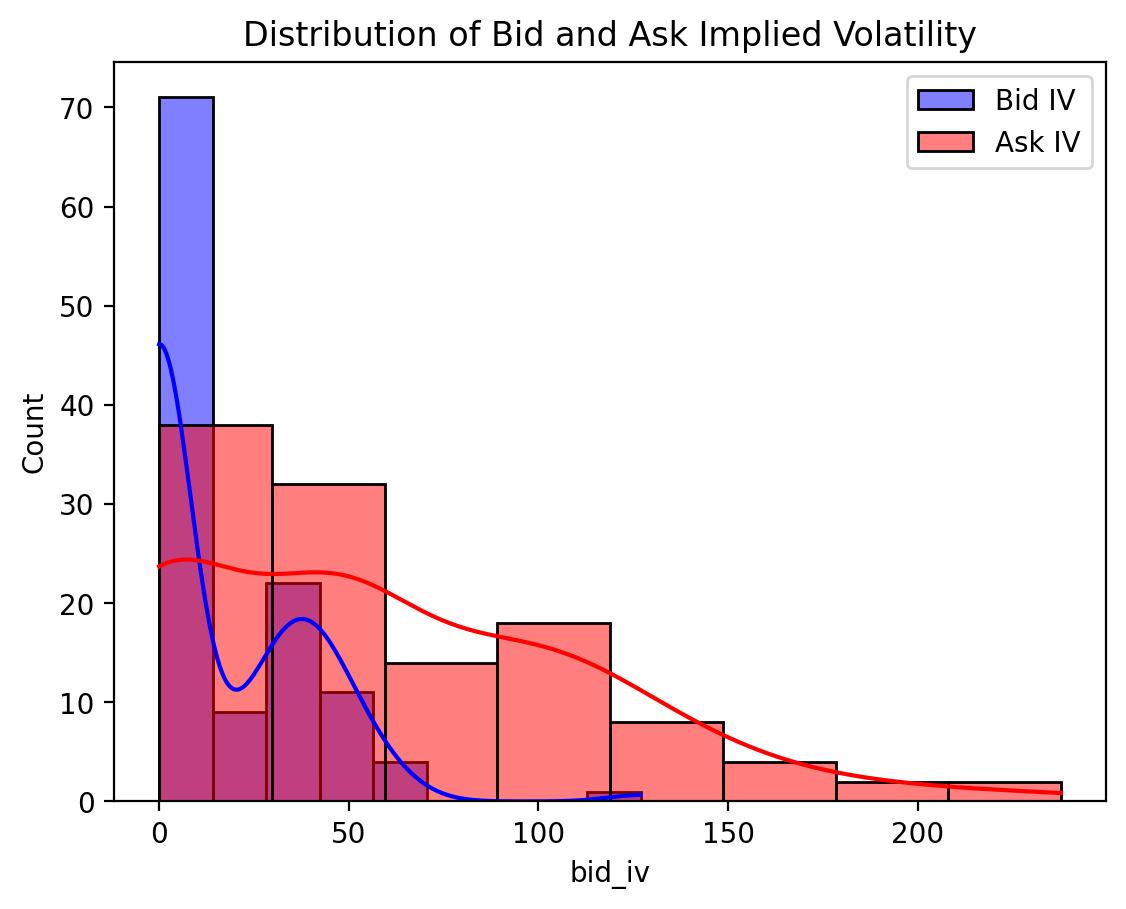

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['bid_iv'].dropna(), color='blue', label='Bid IV', kde=True)
sns.histplot(df['ask_iv'].dropna(), color='red', label='Ask IV', kde=True)
plt.legend()
plt.title('Distribution of Bid and Ask Implied Volatility')
plt.show()


The majority of Bid and Ask IV values are concentrated around lower figures, with a significant peak close to zero. This suggests that many options are perceived to have low volatility, but there is also a noticeable tail extending towards higher values.

In [10]:
median_bid_iv = df['bid_iv'].median()
median_ask_iv = df['ask_iv'].median()
print(f"Median Bid IV: {median_bid_iv}, Median Ask IV: {median_ask_iv}")


Median Bid IV: 0.0, Median Ask IV: 45.405


### Correlation 

In [11]:
import pandas as pd
import numpy as np

num_data = df.select_dtypes(include=['int64', 'float64'])
corr = num_data.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

c:\Users\Ethan Vaz Falcao\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\io\formats\style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
c:\Users\Ethan Vaz Falcao\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\io\formats\style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,best_ask_amount,underlying_price,ask_iv,bid_iv,mark_iv,interest_rate,best_bid_price,best_ask_price,mark_price,open_interest,max_price,min_price,settlement_price,last_price,index_price,change_id,timestamp,greeks.rho,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high,Strike Price
best_ask_amount,1.000000,0.473607,0.610422,-0.061316,-0.173704,nan,-0.073601,0.441364,-0.214470,-0.092731,-0.221533,-0.235019,-0.226108,-0.224633,-0.397301,0.128588,-0.370559,0.083641,-0.036037,-0.405192,0.029478,-0.228749,-0.017956,-0.059364,0.141185,0.561954,0.411518,0.054096
underlying_price,0.473607,1.000000,0.463093,0.164821,-0.661568,nan,-0.157911,0.088029,-0.583208,-0.067116,-0.618934,-0.561319,-0.524667,-0.594919,-0.639154,-0.146613,-0.875449,0.175899,-0.292353,-0.816509,0.432992,-0.061349,0.134339,0.184114,-0.203141,0.141048,0.129996,0.127726
ask_iv,0.610422,0.463093,1.000000,-0.138243,-0.028730,nan,-0.128443,0.750250,-0.365949,-0.061303,-0.373338,-0.387186,-0.443432,-0.402810,-0.381057,0.203741,-0.359628,0.148935,0.199446,-0.407928,-0.166013,-0.176814,-0.004816,-0.055071,0.096702,0.693727,0.438139,0.154677
bid_iv,-0.061316,0.164821,-0.138243,1.000000,-0.305090,nan,0.265694,-0.144815,-0.202860,0.081196,-0.213590,-0.176598,-0.073720,-0.178066,-0.296744,0.137664,-0.015997,0.224252,-0.382544,-0.098286,0.185234,0.133698,0.093485,0.080115,0.032993,-0.356235,-0.369900,0.097231
mark_iv,-0.173704,-0.661568,-0.028730,-0.305090,1.000000,nan,0.268637,0.027947,0.535747,0.047704,0.515242,0.542238,0.479085,0.519602,0.409920,0.207901,0.484953,-0.017077,0.659137,0.249804,-0.644601,0.085771,-0.181568,-0.229851,-0.050896,0.291631,0.049241,-0.397962
interest_rate,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
best_bid_price,-0.073601,-0.157911,-0.128443,0.265694,0.268637,nan,1.000000,-0.042412,0.378536,0.050127,0.346407,0.398461,0.401926,0.390334,0.029455,0.039411,0.109003,0.166112,0.058042,-0.018598,-0.075089,0.244318,0.010482,-0.006757,0.131001,0.190271,0.281027,-0.295992
best_ask_price,0.441364,0.088029,0.750250,-0.144815,0.027947,nan,-0.042412,1.000000,-0.156783,-0.137985,-0.135587,-0.204513,-0.234019,-0.149547,-0.120116,0.123846,0.010671,0.117247,0.083455,-0.060626,-0.195414,-0.000160,0.037011,-0.033094,0.156683,0.908880,0.809708,0.159468
mark_price,-0.214470,-0.583208,-0.365949,-0.202860,0.535747,nan,0.378536,-0.156783,1.000000,-0.067599,0.994408,0.994547,0.998224,0.975540,0.394114,0.089388,0.489617,-0.320023,0.256814,0.352205,-0.293943,0.084249,-0.082654,-0.119016,0.139487,0.930308,0.884511,-0.106935
open_interest,-0.092731,-0.067116,-0.061303,0.081196,0.047704,nan,0.050127,-0.137985,-0.067599,1.000000,-0.065132,-0.062762,-0.145803,-0.121629,0.174823,0.073335,-0.051984,0.205858,0.157571,0.148366,-0.012919,0.163397,-0.027003,0.068568,-0.267740,-0.203412,-0.217781,0.040982


In [12]:
btc_data = df

### Options Greeks Visualization

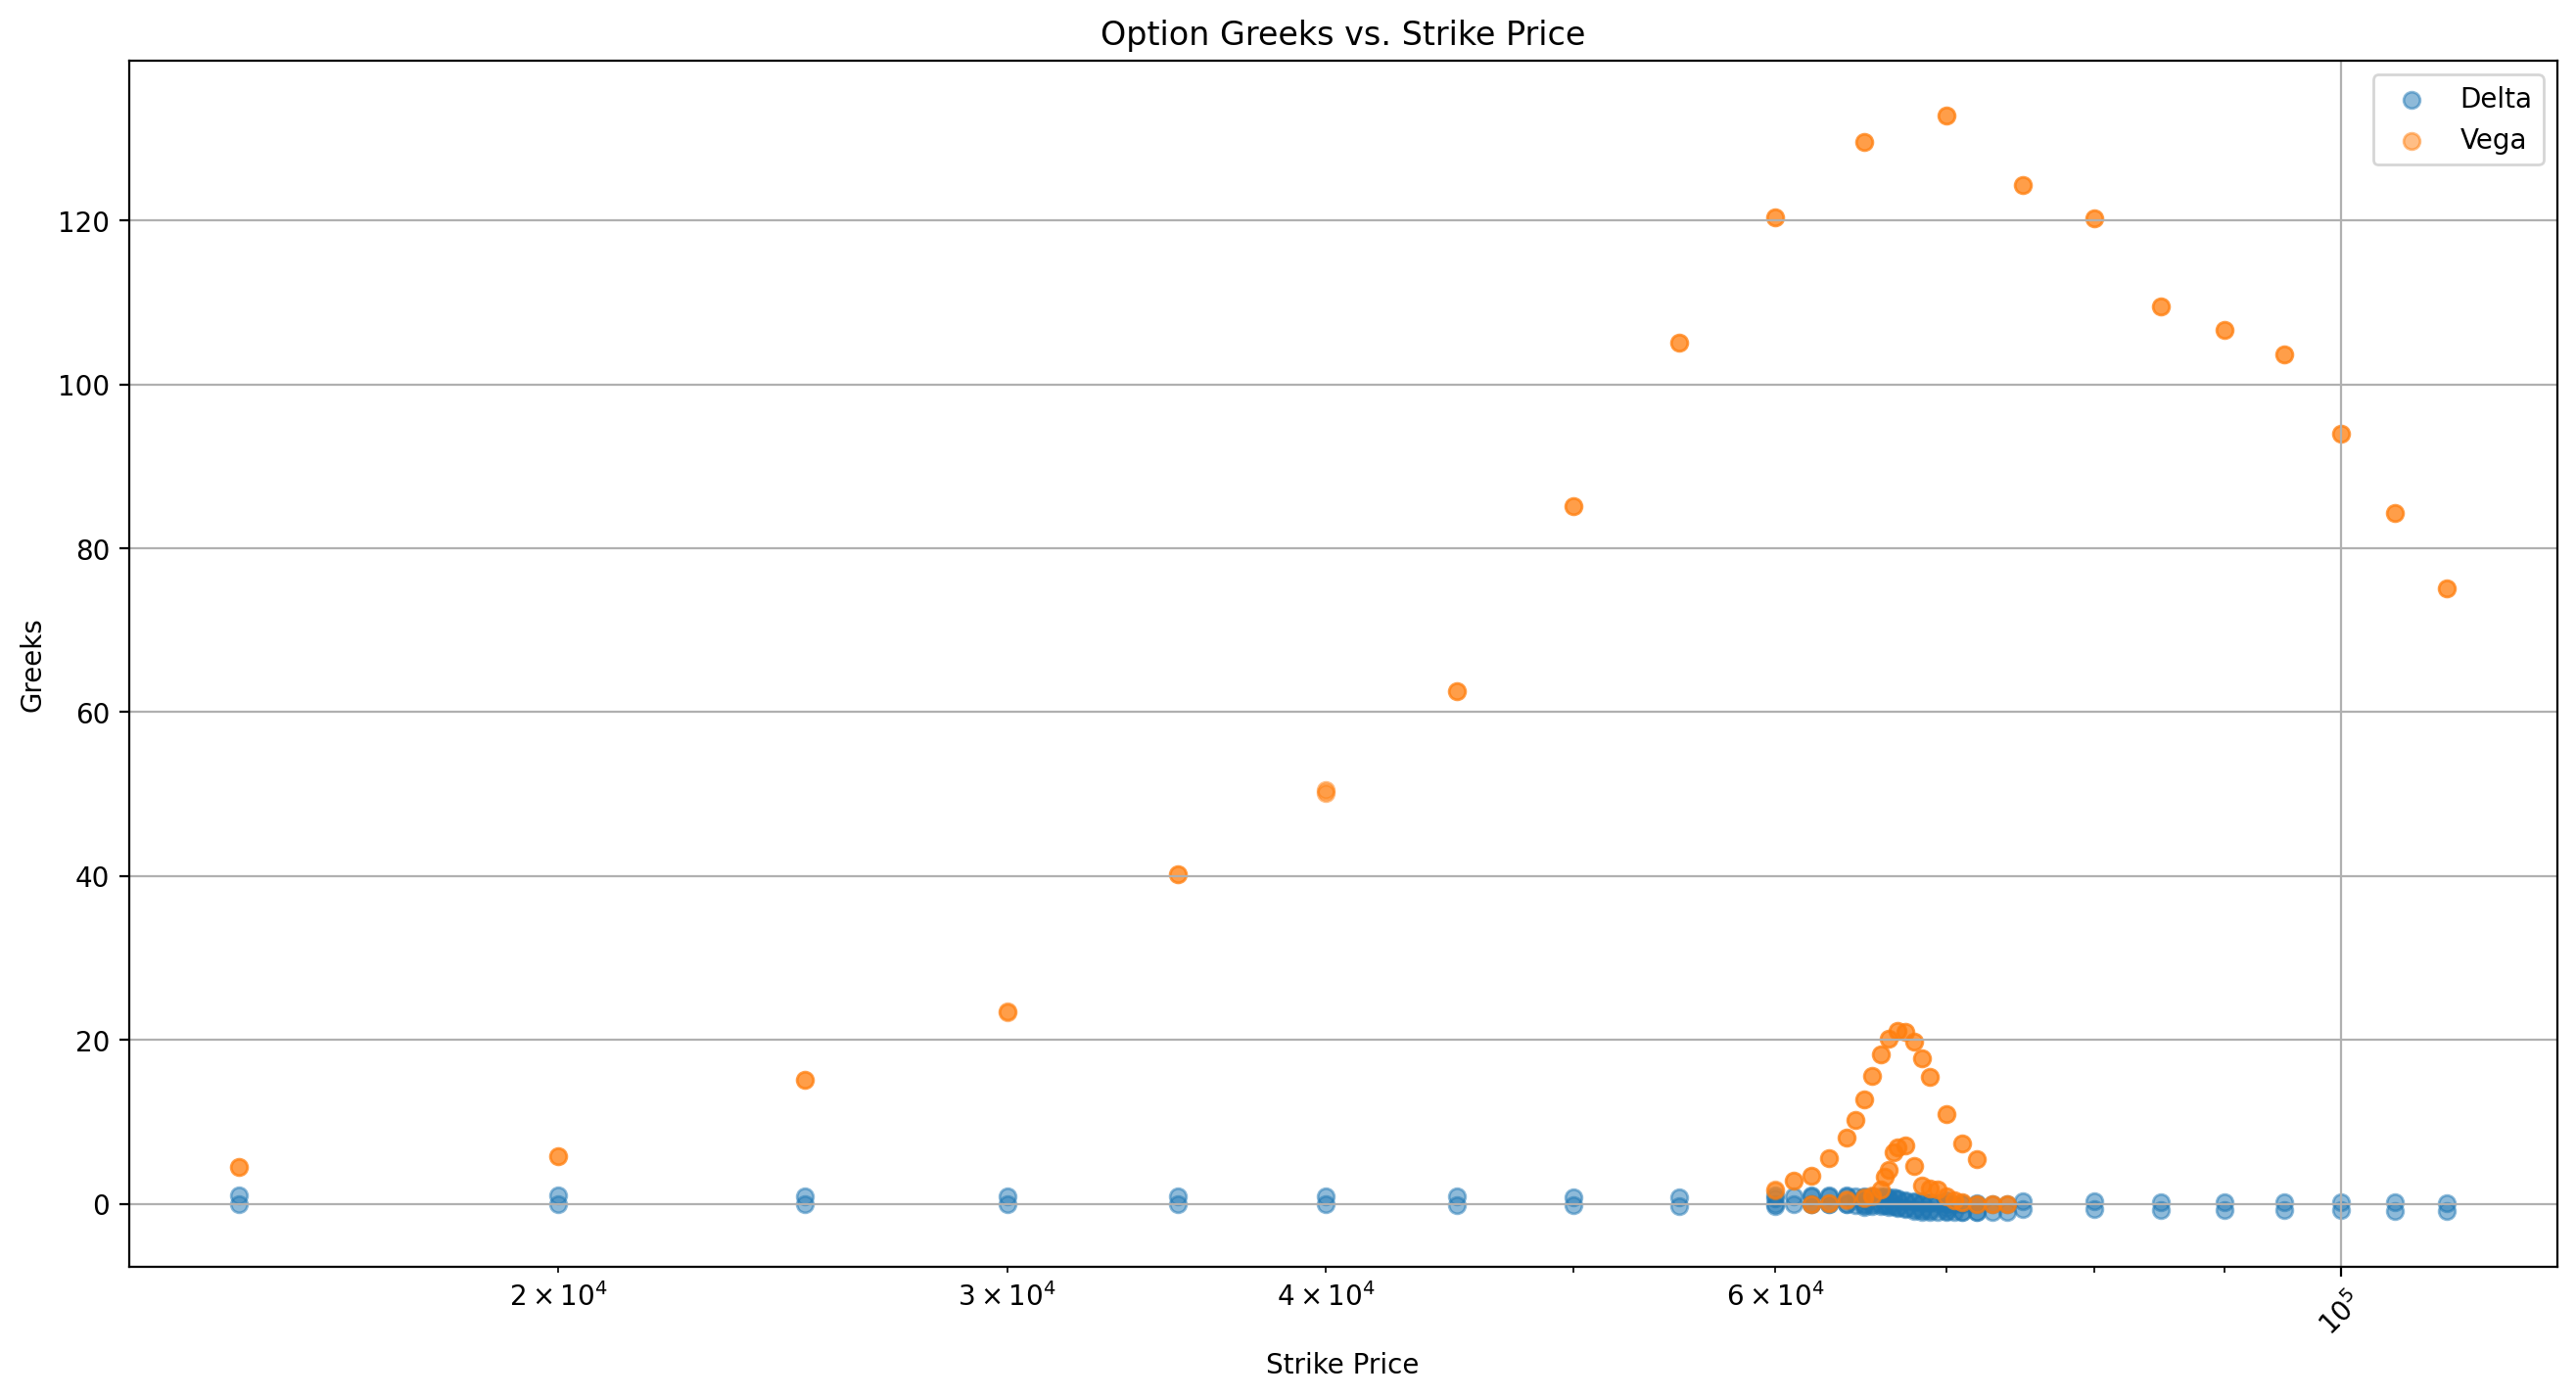

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))  # Larger figure size
plt.scatter(df['Strike Price'], df['greeks.delta'], label='Delta', alpha=0.5)
plt.scatter(df['Strike Price'], df['greeks.vega'], label='Vega', alpha=0.5)
plt.title('Option Greeks vs. Strike Price')
plt.xlabel('Strike Price')
plt.ylabel('Greeks')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.xscale('log')  # Optional: Only use if appropriate for your data range
plt.grid(True)  # Enable grid for better readability
plt.legend()
plt.show()


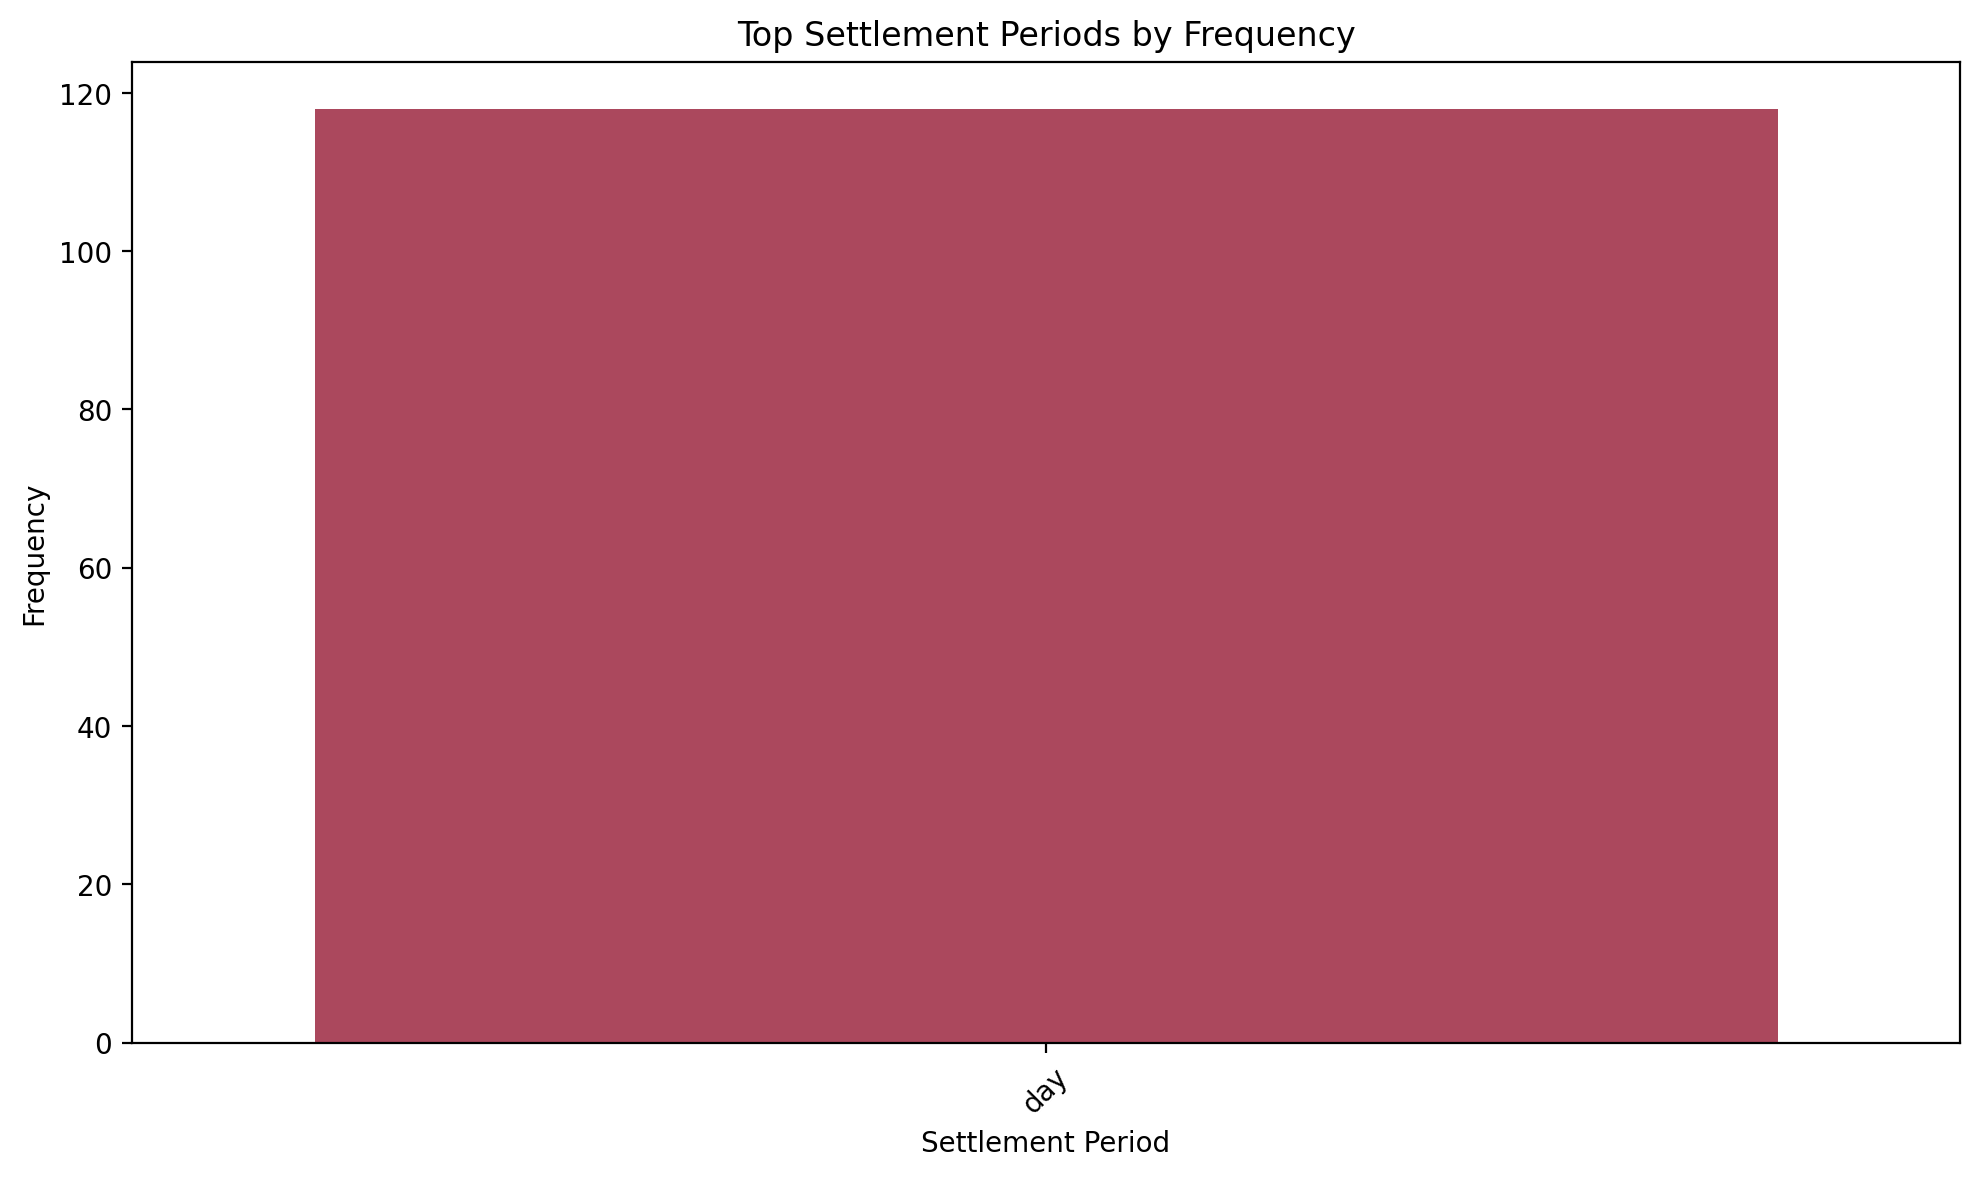

In [ ]:
# Compute the frequency of each unique settlement period
btc_settlement_freq = df['settlement_period'].value_counts().reset_index()
btc_settlement_freq.columns = ['settlement_period', 'Frequency']  # Renaming columns appropriately

# Creating a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='settlement_period', y='Frequency', data=btc_settlement_freq, palette="inferno")
plt.xticks(rotation=45)
plt.xlabel('Settlement Period')
plt.ylabel('Frequency')
plt.title('Top Settlement Periods by Frequency')
plt.tight_layout()
plt.show()

## Correlation

In [ ]:
import pandas as pd
import numpy as np

num_data = df.select_dtypes(include=['int64', 'float64'])
corr = num_data.corr()
corr.style.background_gradient(cmap='coolwarm')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

,best_bid_amount,best_ask_amount,bid_iv,ask_iv,underlying_price,mark_iv,best_bid_price,best_ask_price,open_interest,max_price,min_price,last_price,settlement_price,mark_price,index_price,change_id,timestamp,greeks.rho,greeks.theta,greeks.vega,greeks.gamma,greeks.delta,stats.volume_usd,stats.volume,stats.price_change,stats.low,stats.high
best_bid_amount,1.000000,0.272543,0.014559,-0.011954,0.034158,-0.055853,0.045808,0.085703,0.037725,0.014612,-0.005632,-0.009563,-0.004528,-0.016192,0.097655,0.039849,-0.119664,0.032766,-0.184346,-0.146322,0.042671,0.009243,0.015931,0.018107,-0.024624,0.088392,0.066286
best_ask_amount,0.272543,1.000000,0.003644,0.091215,0.180338,-0.184907,0.067065,0.202010,0.007295,0.054128,-0.044528,-0.063962,-0.015114,-0.031592,0.273358,0.074072,-0.340396,0.026556,-0.296572,-0.276277,0.120102,-0.155406,-0.011891,0.054300,-0.042284,-0.070283,-0.084860
bid_iv,0.014559,0.003644,1.000000,-0.119055,-0.058624,-0.138004,0.037531,-0.061777,0.056681,-0.149284,-0.147279,-0.097303,-0.180109,-0.157930,-0.014961,0.075157,-0.008077,0.088139,-0.081310,-0.025548,0.016141,0.124410,0.487974,0.554886,0.011028,-0.059635,0.035974
ask_iv,-0.011954,0.091215,-0.119055,1.000000,0.307028,0.305881,-0.027171,0.142988,0.035149,-0.166477,-0.120897,-0.124477,-0.133431,-0.132225,0.368757,0.088751,-0.401486,0.121175,0.139656,-0.347766,-0.097729,-0.039555,-0.068284,-0.055495,0.164752,-0.130307,-0.155935
underlying_price,0.034158,0.180338,-0.058624,0.307028,1.000000,0.090441,-0.250090,-0.214028,-0.130046,-0.020514,-0.150854,-0.142954,-0.116553,-0.152672,0.516460,-0.081639,-0.610695,0.042923,-0.272998,-0.296734,0.211076,-0.050469,0.093844,0.161835,0.072596,-0.167070,-0.148294
mark_iv,-0.055853,-0.184907,-0.138004,0.305881,0.090441,1.000000,0.012272,0.132110,-0.093063,0.161993,0.250512,0.240849,0.238205,0.245483,0.053311,0.072454,0.079763,-0.069214,0.226428,-0.033428,-0.439793,-0.082540,-0.047736,-0.165896,0.072408,0.210313,0.189890
best_bid_price,0.045808,0.067065,0.037531,-0.027171,-0.250090,0.012272,1.000000,0.667777,0.061480,0.459902,0.463080,0.470482,0.471835,0.485546,-0.209857,0.049931,0.252356,-0.350421,0.096584,0.102894,-0.079548,-0.145842,-0.000382,-0.048572,-0.030210,0.466249,0.441105
best_ask_price,0.085703,0.202010,-0.061777,0.142988,-0.214028,0.132110,0.667777,1.000000,0.063920,0.554909,0.588629,0.597627,0.602842,0.600400,-0.115452,0.057432,0.187072,-0.308634,0.159160,-0.014894,-0.113433,-0.182082,-0.017352,-0.059204,-0.023118,0.601626,0.557184
open_interest,0.037725,0.007295,0.056681,0.035149,-0.130046,-0.093063,0.061480,0.063920,1.000000,-0.136198,-0.057678,-0.082254,-0.083174,-0.074600,0.036401,0.061071,0.012626,0.071618,0.165880,-0.110186,-0.069989,0.016939,-0.027687,-0.019316,0.005135,-0.043281,-0.062479
max_price,0.014612,0.054128,-0.149284,-0.166477,-0.020514,0.161993,0.459902,0.554909,-0.136198,1.000000,0.919373,0.898553,0.954717,0.952191,-0.206813,-0.069002,0.250077,-0.723589,0.021779,0.118461,-0.046615,-0.399419,0.213014,-0.000857,-0.062552,0.897261,0.893357
